In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import json
import pprint
import tensorflow as tf
import matplotlib.pyplot as plt

2025-11-17 14:40:13.044126: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
root_dir = "datasets"
tfrecords_dir = "tfrecords"
images_dir = os.path.join(root_dir, "val2017")
annotations_dir = os.path.join(root_dir, "annotations")
annotation_file = os.path.join(annotations_dir, "instances_val2017.json")
images_url = "http://images.cocodataset.org/zips/val2017.zip"
annotations_url = (
    "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
)

# Download image files
if not os.path.exists(images_dir):
    image_zip = keras.utils.get_file(
        "images.zip",
        cache_dir=os.path.abspath("."),
        origin=images_url,
        extract=True,
    )
    #os.remove(image_zip)

# Download caption annotation files
if not os.path.exists(annotations_dir):
    annotation_zip = keras.utils.get_file(
        "captions.zip",
        cache_dir=os.path.abspath("."),
        origin=annotations_url,
        extract=True,
    )
    #os.remove(annotation_zip)

print("The COCO dataset has been downloaded and extracted successfully.")

with open(annotation_file, "r") as f:
    annotations = json.load(f)["annotations"]

print(f"Number of images: {len(annotations)}")

The COCO dataset has been downloaded and extracted successfully.
Number of images: 36781


In [3]:
pprint.pprint(annotations[60])

{'area': 367.89710000000014,
 'bbox': [265.67, 222.31, 26.48, 14.71],
 'category_id': 72,
 'id': 34096,
 'image_id': 525083,
 'iscrowd': 0,
 'segmentation': [[267.51,
                   222.31,
                   292.15,
                   222.31,
                   291.05,
                   237.02,
                   265.67,
                   237.02]]}


In [4]:
num_samples = 4096
num_tfrecords = len(annotations) // num_samples
if len(annotations) % num_samples:
    num_tfrecords += 1  # add one record if there are any remaining samples

if not os.path.exists(tfrecords_dir):
    os.makedirs(tfrecords_dir)  # creating TFRecords output folder

In [5]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_example(image, path, example):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "area": float_feature(example["area"]),
        "bbox": float_feature_list(example["bbox"]),
        "category_id": int64_feature(example["category_id"]),
        "id": int64_feature(example["id"]),
        "image_id": int64_feature(example["image_id"]),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "area": tf.io.FixedLenFeature([], tf.float32),
        "bbox": tf.io.VarLenFeature(tf.float32),
        "category_id": tf.io.FixedLenFeature([], tf.int64),
        "id": tf.io.FixedLenFeature([], tf.int64),
        "image_id": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["bbox"] = tf.sparse.to_dense(example["bbox"])
    return example

In [6]:
for tfrec_num in range(num_tfrecords):
    samples = annotations[(tfrec_num * num_samples) : ((tfrec_num + 1) * num_samples)]

    with tf.io.TFRecordWriter(
        tfrecords_dir + "/file_%.2i-%i.tfrec" % (tfrec_num, len(samples))
    ) as writer:
        for sample in samples:
            image_path = f"{images_dir}/{sample['image_id']:012d}.jpg"
            image = tf.io.decode_jpeg(tf.io.read_file(image_path))
            example = create_example(image, image_path, sample)
            writer.write(example.SerializeToString())

I0000 00:00:1763386838.159803   18451 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8932 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


bbox: [473.07 395.93  38.65  28.67]
area: 702.1057739257812
category_id: 18
id: 1768
image_id: 289343
path: b'datasets/val2017/000000289343.jpg'
Image shape: (640, 529, 3)


2025-11-17 14:42:47.440557: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:390] TFRecordDataset `buffer_size` is unspecified, default to 262144


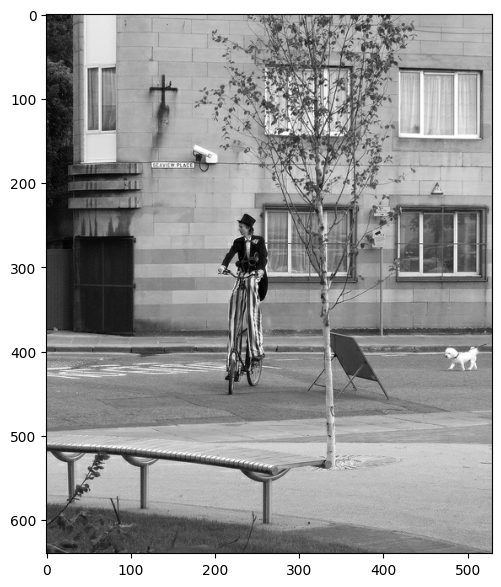

2025-11-17 14:42:47.572552: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
raw_dataset = tf.data.TFRecordDataset(f"{tfrecords_dir}/file_00-{num_samples}.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()

In [8]:
def prepare_sample(features):
    image = keras.ops.image.resize(features["image"], size=(224, 224))
    return image, features["category_id"]


def get_dataset(filenames, batch_size):
    dataset = (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
        .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
        .map(prepare_sample, num_parallel_calls=AUTOTUNE)
        .shuffle(batch_size * 10)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )
    return dataset


train_filenames = tf.io.gfile.glob(f"{tfrecords_dir}/*.tfrec")
batch_size = 32
epochs = 1
steps_per_epoch = 50
AUTOTUNE = tf.data.AUTOTUNE

input_tensor = keras.layers.Input(shape=(224, 224, 3), name="image")
model = keras.applications.EfficientNetB0(
    input_tensor=input_tensor, weights=None, classes=91
)


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)


model.fit(
    x=get_dataset(train_filenames, batch_size),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=1,
)

2025-11-17 14:43:03.053188: I external/local_xla/xla/service/service.cc:163] XLA service 0x781d0401dc20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-17 14:43:03.053210: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-17 14:43:03.489889: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-17 14:43:06.202963: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-11-17 14:43:08.859402: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:43:08.980385: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed ou

50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 54ms/step - loss: 3.7518 - sparse_categorical_accuracy: 0.2069
